# 신궁 고장 예측

> Context

- 개요
- Data 전처리 및 EDA
- 머신러닝 알고리즘 선정 및 모델 학습
- 알고리즘별 평가
- 정확도 향상을 위한 Scoring기반 Threshold 조정

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 개요

```
비운용 유휴 유도탄의 상태를 간접적으로 진단해 별도의 점검장비 및 시설없이 뱇 ㅣ현장에서 즉각적으로 유도탄의 상태를 진단/추정 하고자 한다.
상태 모니터링의 절차는 모델 수립 단계와 모니터링 단계로 구분하며, 모델 수립 단계에서는 정상 환경 조건과 야전 환경 차이를 수명 가속 계수로 변환하는 수학적 가속 모델을 수립하고 초기 신뢰도 분석 분석을 통해 신뢰도 기준선을 설정한다. 모니터링 단계에서는 배치 유도탄으로부터 수집된 환경데이터를 기반으로 가속 계수를 산출하고, 그 결과를 통해 유도탄 노화 수준 및 여러 신뢰도 척도를 계산하여 사용자에게 제공하며, 각종 야전 데이터를 반영하여 가속 모델을 업데이트 하고자 한다.
이를 통해 기존 로트(Lot) 또는 배치 단위의 유도탄 관리가 아닌 개별 유도탄에 대한 상태 진단/모니터링을 통한 관리로 패러다임을 전환하고자 한다.
```

> 문제정의
- 실시간 고장 예측의 어려움으로 인한 많은 자원 낭비
- 유도탄 신뢰성 예측의 어려움으로 인한 훈련 및 비상사태 수행 오류

> 기대효과
- 정비/운용요원이 별도의 점검장비 및 시설없이 배치 현장에서 즉각적으로 유도탄 상태를 진단/추정하여 유도탄 고장으로 인한 리스크 감소
- 배치 단위의 관리를 개별 유도탄 관리로 가능하게 하여 보다 정확한 유도탄 정비계획 수립으로 불필요한 자원소모 감소

> 해결방안
- 실시간 환경정보 수집 및 분석을 통한 유도탄 신뢰성/건전성 평가 척도 제공

> 성과측정 (KPI)
- 환경데이터 기반 상태 진단 적용 전/후 고장 유도탄으로 진행되는 훈련횟수 비교
- 정비/운용요원의 만족도 조사

# Data 전처리

In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# 군수데이터
df = pd.read_excel('A 데이터 정리.xlsx', engine='openpyxl')
# 센서데이터 (확보 중)


,(1)순,(1-2)순\n_유도탄,(2)대상체계,(3)유도탄 품명,(4)유도탄 \n국가재고번호,(5)LOT,(6)S/N,(7)제조일자\n(재산현황기준),(8)운용시작일\n(납품년월),(9)운용종료일,(10)운용시간,누적운용시간,START,END,(11)운용부대\n- 보유부대,(12)운용지역,(13)이벤트 부호,(14)이벤트\n 시작일자,(15)이벤트 \n종료일자,(16)이벤트 수행부대,(17)이벤트 경위,야전점검\n점검결과,"고장판단\n(0: 마지막 무고장 점검시점, 1:최초 고장 품목이 식별된 점검시점)",(18)고장판단,이벤트단위코드1,이벤트단위코드2,고장판단(그룹핑),(18-A)판정,(18-B)신호명,(18-C)기준값,(18-D)출력값,(19)고장원인,(20)조치내용,(21)교체품 품명,(22)교체품 재고번호,(23)교체품S/N-OUT품목,(24)교체품S/N-IN품목,(25)비 고
0,1.0,1.0,신궁(육군),NaN,NaN,NaN,SG05A00100,NaT,2005-09-01,2005-09-15 00:00:00,336.0,336,336.0,*,NaN,NaN,A3,2005-09-15,2005-09-15,NaN,유도탄 실사격(명중),NaN,0,NaN,A,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,2.0,신궁(육군),NaN,NaN,NaN,SG05A00200,NaT,2005-12-29,2006-09-15 00:00:00,6240.0,6240,6240.0,*,NaN,NaN,A3,2006-09-15,2006-09-15,NaN,유도탄 실사격(명중),NaN,0,NaN,A,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,3.0,신궁(육군),NaN,NaN,NaN,SG05A00300,NaT,2005-12-29,2007-10-26 00:00:00,15984.0,15984,15984.0,*,NaN,NaN,A3,2007-10-26,2007-10-26,NaN,유도탄 실사격(명중),NaN,0,NaN,A,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,4.0,신궁(육군),신궁유도탄 SAM-1K,NaN,넥스원05카056-001,SG05A01300,NaT,2005-12-29,2020-09-03 00:00:00,77040.0,77040,15984.0,77040,AA33,NaN,A1 B1,2014-10-13,2014-10-13,AA33,"야전 정기검사(5년 주기)\n - BCU 무게 불량 확인, BCU 교체 수행",불합격,1,고장,A,1,전원부 고장,BCU 고장,BCU 무게,최초무게,최초무게-10g,NaN,NaN,BCU,NaN,5028.0,NaN,NaN
4,5.0,5.0,신궁(육군),신궁유도탄 SAM-1K,NaN,넥스원05카056-001,SG05A01400,NaT,2005-12-29,NaN,77256.0,77256,NaN,NaN,AA33,NaN,A1,2014-10-22,2014-10-22,AA33,야전 정기검사(5년주기)(합격),합격,NaN,NaN,A,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# 보유 데이터 파악 (rows = 3832, columns = 38)
df.shape

(3832, 38)

In [4]:
# 데이터 Type 확인 (총 38건 중 날짜 4건, 실수 5건, 문자열 29건)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 38 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   (1)순                                          3830 non-null   float64       
 1   (1-2)순
_유도탄                                   591 non-null    float64       
 2   (2)대상체계                                       3822 non-null   object        
 3   (3)유도탄 품명                                     3303 non-null   object        
 4   (4)유도탄 
국가재고번호                                1 non-null      object        
 5   (5)LOT                                        3306 non-null   object        
 6   (6)S/N                                        3831 non-null   object        
 7   (7)제조일자
(재산현황기준)                              2890 non-null   datetime64[ns]
 8   (8)운용시작일
(납품년월)                               3829 non-null   dateti

In [5]:
# Column 별 NaN값 확인 (결측치가 많아 각 Column별로 해결방안 수립이 필요)
df.isnull().sum()

(1)순                                                2
(1-2)순\n_유도탄                                     3241
(2)대상체계                                            10
(3)유도탄 품명                                         529
(4)유도탄 \n국가재고번호                                  3831
(5)LOT                                            526
(6)S/N                                              1
(7)제조일자\n(재산현황기준)                                 942
(8)운용시작일\n(납품년월)                                    3
(9)운용종료일                                         1598
(10)운용시간                                          280
누적운용시간                                             17
START                                            1442
END                                              1442
(11)운용부대\n- 보유부대                                  613
(12)운용지역                                         3801
(13)이벤트 부호                                         22
(14)이벤트\n 시작일자                                      2
(15)이벤트 \n종료일자              

In [6]:
# 이상 데이터 점검 (=> 운용시간의 min값에서 마이너스가 발견됨)
df.describe()

,(1)순,(1-2)순\n_유도탄,(10)운용시간,START,(23)교체품S/N-OUT품목
count,3830.000000,591.000000,3.552000e+03,2.390000e+03,3.000000
mean,1915.500000,146.925550,4.538120e+04,6.743812e+04,20355.666667
std,1105.770094,99.628588,5.892228e+04,7.732357e+04,26545.699394
min,1.000000,1.000000,-3.720000e+03,0.000000e+00,5028.000000
25%,958.250000,74.000000,2.452800e+04,3.902400e+04,5029.500000
50%,1915.500000,123.000000,3.960000e+04,6.583200e+04,5031.000000
75%,2872.750000,218.500000,5.155200e+04,9.056400e+04,28019.500000
max,3830.000000,382.000000,1.057536e+06,2.171808e+06,51008.000000


In [7]:
# 운용시간이 마이너스값인 컬럼을 식별
df_minus_time = df[df['(10)운용시간'] < 0]
df_minus_time['(10)운용시간']

409      -24.0
833    -3720.0
1109   -3480.0
1191   -1320.0
1276   -2208.0
3186   -1008.0
3190   -1008.0
3194   -1008.0
Name: (10)운용시간, dtype: float64

In [11]:
# 데이터 확인
# => '고장 판단'값이 문자열로 제각각 되어있어 머신러닝 적용에 적합하지 않아 적절한 사전 처리가 필요함
# => '고장 판단' 에서 결측치가 발견됨
# => 유도탄 건전성에 대해 (1-2)순\n유도탄, S/N, 운용시간, 누적운용시간, 이벤트부호, 이벤트 수행부대, 고장판단(0,1), (18)고장판단, 고장판단(그룹핑), 교체품 품명 데이터가 가능한 것으로 판단됨
df.head(2)

,(1)순,(1-2)순\n_유도탄,(2)대상체계,(3)유도탄 품명,(4)유도탄 \n국가재고번호,(5)LOT,(6)S/N,(7)제조일자\n(재산현황기준),(8)운용시작일\n(납품년월),(9)운용종료일,(10)운용시간,누적운용시간,START,END,(11)운용부대\n- 보유부대,(12)운용지역,(13)이벤트 부호,(14)이벤트\n 시작일자,(15)이벤트 \n종료일자,(16)이벤트 수행부대,(17)이벤트 경위,야전점검\n점검결과,"고장판단\n(0: 마지막 무고장 점검시점, 1:최초 고장 품목이 식별된 점검시점)",(18)고장판단,이벤트단위코드1,이벤트단위코드2,고장판단(그룹핑),(18-A)판정,(18-B)신호명,(18-C)기준값,(18-D)출력값,(19)고장원인,(20)조치내용,(21)교체품 품명,(22)교체품 재고번호,(23)교체품S/N-OUT품목,(24)교체품S/N-IN품목,(25)비 고
0,1.0,1.0,신궁(육군),NaN,NaN,NaN,SG05A00100,NaT,2005-09-01,2005-09-15 00:00:00,336.0,336,336.0,*,NaN,NaN,A3,2005-09-15,2005-09-15,NaN,유도탄 실사격(명중),NaN,0,NaN,A,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,2.0,신궁(육군),NaN,NaN,NaN,SG05A00200,NaT,2005-12-29,2006-09-15 00:00:00,6240.0,6240,6240.0,*,NaN,NaN,A3,2006-09-15,2006-09-15,NaN,유도탄 실사격(명중),NaN,0,NaN,A,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


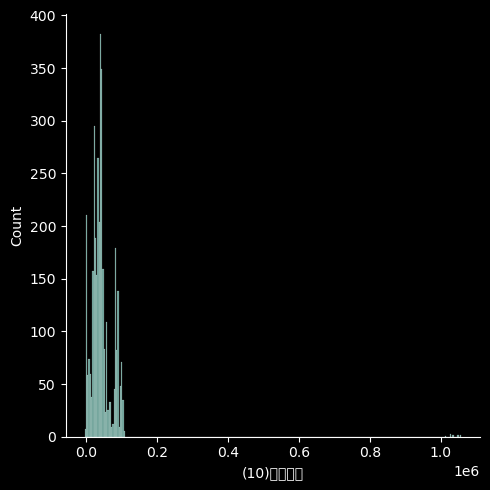

In [12]:
# 이상치 확인
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

sns.displot(df['(10)운용시간']);

SyntaxError: invalid syntax (2796632577.py, line 2)